In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from utils.utils import Fill_NC_With_Station_Values, aggregate_per_timestep_xr, calculate_metrics
from era5.era5_cropper import Era5ForStationCropper
from train_station_twin.prepare_training_executor_era5 import TrainingPreparation
import torch


In [2]:
# Load ERA5 Data
# this covers the period 2020-2023 and is in 9x9 grid
era5 = xr.open_dataset('era5_data/era5_barbados_allvar/barbados_all_var_2020_2024_renamed.nc')
era5

<xarray.Dataset>
Dimensions:  (time: 42783, lon: 17, lat: 17)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2024-11-17T14:00:00
  * lon      (lon) float64 298.5 298.7 299.0 299.2 ... 301.7 302.0 302.2 302.5
  * lat      (lat) float64 15.17 14.91 14.66 14.41 ... 11.91 11.66 11.41 11.16
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    2d       (time, lat, lon) float32 ...
    2t       (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Nov 26 15:37:19 2024: cdo -f nc4 copy era5_data/era5_ba...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

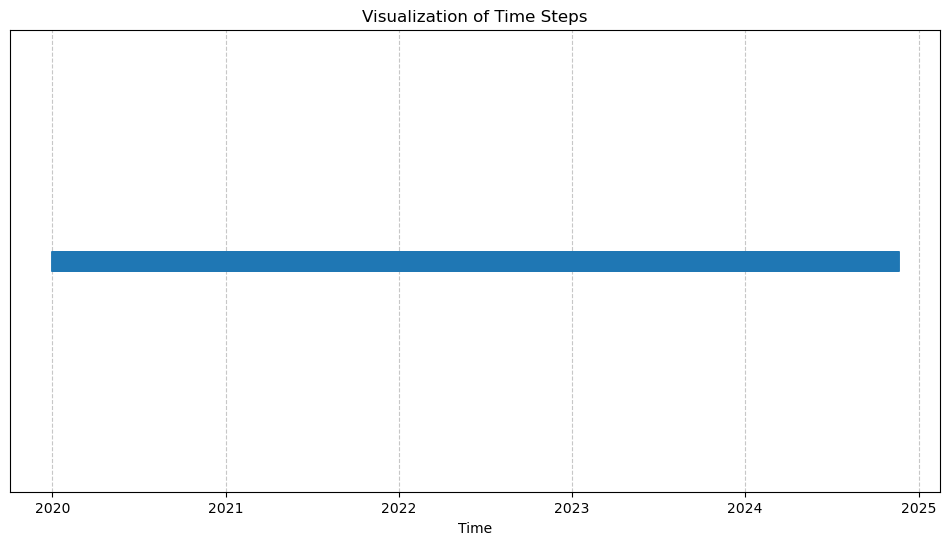

In [3]:
# Open your dataset

# Extract the time coordinate
time_steps = era5['time']

# Plot the time steps
plt.figure(figsize=(12, 6))
plt.plot(time_steps, [1] * len(time_steps), '|', markersize=15)  # Mark each timestep
plt.title("Visualization of Time Steps")
plt.xlabel("Time")
plt.yticks([])  # Hide y-axis labels
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [4]:
# load hourly station data
barbados_hourly_df = pd.read_csv("station_data_processed/barbados_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)
barbados_hourly_df.head()
# barbados_hourly_df["tipping"].dropna()
barbados_hourly_df



,bmp280_temp,bmp280_pres,bmp280_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_speed
datetime,,,,,,,,,,,
2020-06-08 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2020-06-08 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 15:00:00,28.66,982.875,1013.750,10.4,NaN,27.30,0.0,845.0,6304.5,315.0,2.128167
2023-11-22 16:00:00,29.05,982.170,1012.980,11.6,NaN,27.60,0.0,923.0,7158.5,356.5,2.052167
2023-11-22 17:00:00,28.84,981.645,1012.470,11.7,NaN,27.40,0.0,730.0,5044.5,253.5,2.274000


In [5]:

# Example station coordinates (e.g., Berlin)
station_lat = 13.16443 ,
station_lon =  -59.54316


 
measurements = barbados_hourly_df["tipping"]

# Paths to ERA5 datasets
original_era5_path = 'era5_data/era5_barbados_allvar/barbados_all_var_2020_2024_renamed.nc'  # Replace with actual path
cropped_era5_path = 'Training_Babados/cropped_tipping/era5_cropped_tipping.nc'      # Replace with desired output path

# Initialize the cropper
cropper = Era5ForStationCropper(
    latitude=station_lat,
    longitude=station_lon,
    measurements=measurements,
    era5_path=original_era5_path,
    era5_target_path=cropped_era5_path
)

# Execute cropping and retrieve results
cropped_dataset, missing_gaps = cropper.execute()

print("Missing timestamps:", missing_gaps)


Cropping time axis...
Selecting time slice from 2020-06-08 15:00:00 to 2023-11-22 19:00:00
Time-cropped dataset dimensions: Frozen({'time': 30293, 'lon': 17, 'lat': 17})
Dropping missing times...
Number of missing timestamps: 1285
Dataset dimensions after dropping missing times: Frozen({'time': 29008, 'lon': 17, 'lat': 17})
Cropping spatial grid...
Latitudes are sorted in descending order.
Nearest longitude: 300.456 (Index: 8)
Nearest latitude: 13.1645 (Index: 8)
Final cropping indices: start=4, end=12
Final cropping indices: start=4, end=12
Cropping longitude indices: 4 to 12
Cropping latitude indices: 4 to 12
Dataset dimensions after spatial cropping: Frozen({'time': 29008, 'lon': 8, 'lat': 8})
Longitude values after cropping: [299.456 299.706 299.956 300.206 300.456 300.706 300.956 301.206]
Latitude values after cropping: [14.16475   13.9146875 13.664625  13.4145625 13.1645    12.9144375
 12.664375  12.4143125]

Inspecting cropped dataset before saving:
<xarray.Dataset>
Dimensions: 

In [6]:
cropped_era5_path = 'Training_Babados/cropped_tipping/era5_cropped_tipping.nc'
cropped_era5 = xr.open_dataset(cropped_era5_path)
cropped_era5

<xarray.Dataset>
Dimensions:  (time: 29008, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-08T15:00:00 ... 2023-11-22T19:00:00
  * lon      (lon) float64 299.5 299.7 300.0 300.2 300.5 300.7 301.0 301.2
  * lat      (lat) float64 14.16 13.91 13.66 13.41 13.16 12.91 12.66 12.41
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    2d       (time, lat, lon) float32 ...
    2t       (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Nov 26 15:37:19 2024: cdo -f nc4 copy era5_data/era5_ba...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [7]:
# Fill NC with Values with ....
var = "tp"
values = barbados_hourly_df['tipping'].dropna().values
original_path = 'Training_Babados/cropped_tipping/era5_cropped_tipping.nc'   # Replace with desired output path
save_to_path = 'Training_Babados/cropped_tipping/filled_tipping_gt.nc'

Fill_NC_With_Station_Values(var, values, original_path, save_to_path)



In [13]:
era5_u = xr.open_dataset('Training_Vienna/wind/era5_cropped_uwind.nc' )
era5_v = xr.open_dataset('Training_Vienna/wind/era5_cropped_vwind.nc' )

In [14]:
common_times = np.intersect1d(era5_u.time.values, era5_v.time.values)
era5_u = era5_u.sel(time=common_times)
era5_v = era5_v.sel(time=common_times)

In [15]:
gt_u = xr.open_dataset('Training_Vienna/wind/filled_uwind_gt.nc' )
gt_v = xr.open_dataset('Training_Vienna/wind/filled_vwind_gt.nc' )

In [16]:
common_times = np.intersect1d(gt_u.time.values, gt_v.time.values)
gt_u = gt_u.sel(time=common_times)
gt_v = gt_v.sel(time=common_times)

In [8]:
ground_truth_data_path   = 'Training_Babados/cropped_tipping/era5_cropped_tipping.nc'
cropped_era5_path =  'Training_Babados/cropped_tipping/filled_tipping_gt.nc' #Replace with desired output path


cropped_era5 = xr.open_dataset(cropped_era5_path)
gt = xr.open_dataset(ground_truth_data_path)


In [57]:
gt_nonzero = gt.where(gt.tp > 0, drop=True)
filtered_non_zero_times = gt_nonzero.time
gt_nonzero

# 1840 timesteps where the ground truth is non-zero



<xarray.Dataset>
Dimensions:  (time: 1840, lat: 8, lon: 8)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-24T10:00:00 ... 2022-05-24T11:00:00
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
Data variables:
    10u      (time, lat, lon) float32 1.156 1.278 1.42 ... -2.631 -2.665 -2.645
    10v      (time, lat, lon) float32 0.7707 0.7755 0.7938 ... 1.945 2.024 1.992
    dt2m     (time, lat, lon) float32 270.7 270.8 271.1 ... 287.9 287.6 287.5
    t2m      (time, lat, lon) float32 281.5 281.7 281.9 ... 295.4 295.9 296.0
    sp       (time, lat, lon) float32 9.509e+04 9.535e+04 ... 9.923e+04
    tp       (time, lat, lon) float32 0.2 0.2 0.2 0.2 0.2 ... 0.8 0.8 0.8 0.8
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [63]:
gt_zero = gt.where(gt.tp == 0, drop=True)
zero_times = gt_zero.time
size = len(gt_nonzero.time) * 5

random_zero_times = np.random.choice(zero_times, size , replace=False)

zero_subset_gt = gt.sel(time=random_zero_times)
zero_subset_gt

<xarray.Dataset>
Dimensions:  (time: 9200, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 2018-09-11T16:00:00 ... 2017-06-21T02:00:00
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    dt2m     (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [62]:
zero_subset_era5 = cropped_era5.sel(time=random_zero_times)
zero_subset_era5

<xarray.Dataset>
Dimensions:  (time: 9200, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-09T21:00:00 ... 2018-01-30T13:00:00
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    dt2m     (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [64]:
# num_duplicates = 20  # Adjust this as needed

# gt_repeated = xr.concat([gt_nonzero] * num_duplicates, dim="time")
gt_combined = xr.concat([gt_nonzero, zero_subset_gt], dim="time")
gt_combined 

<xarray.Dataset>
Dimensions:  (time: 11040, lat: 8, lon: 8)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-24T10:00:00 ... 2017-06-21T02:00:00
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
Data variables:
    10u      (time, lat, lon) float32 1.156 1.278 1.42 ... 1.993 1.778 1.493
    10v      (time, lat, lon) float32 0.7707 0.7755 0.7938 ... 0.6817 1.488
    dt2m     (time, lat, lon) float32 270.7 270.8 271.1 ... 287.9 288.1 287.9
    t2m      (time, lat, lon) float32 281.5 281.7 281.9 ... 293.3 293.4 293.2
    sp       (time, lat, lon) float32 9.509e+04 9.535e+04 ... 9.965e+04
    tp       (time, lat, lon) float32 0.2 0.2 0.2 0.2 0.2 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [70]:
cropped_era5_filtered_nonzero = cropped_era5.sel(time=filtered_non_zero_times)
#cropped_repeated = xr.concat([cropped_era5_filtered_nonzero] * num_duplicates, dim="time")
zero_subset_era5 = cropped_era5.sel(time=random_zero_times)
cropped_data_combined = xr.concat([cropped_era5_filtered_nonzero, zero_subset_era5], dim="time")
cropped_data_combined

<xarray.Dataset>
Dimensions:  (time: 11040, lon: 8, lat: 8)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-24T10:00:00 ... 2017-06-21T02:00:00
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
Data variables:
    10u      (time, lat, lon) float32 1.156 1.278 1.42 ... 1.993 1.778 1.493
    10v      (time, lat, lon) float32 0.7707 0.7755 0.7938 ... 0.6817 1.488
    dt2m     (time, lat, lon) float32 270.7 270.8 271.1 ... 287.9 288.1 287.9
    t2m      (time, lat, lon) float32 281.5 281.7 281.9 ... 293.3 293.4 293.2
    sp       (time, lat, lon) float32 9.509e+04 9.535e+04 ... 9.965e+04
    tp       (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [79]:
# Path to your ERA5 data file (optional)
      # Replace with desired output path

ground_truth_data_path   = 'Training_Vienna/cropped_tipping/filled_tipping_gt.nc'
cropped_era5_path =  'Training_Vienna/cropped_tipping/era5_cropped_tipping.nc'

In [80]:
xr_era5 = xr.open_dataset(cropped_era5_path)
xr_era5["tp"].values

array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.000

In [5]:
ground_truth_data_path   = 'Training_Babados/cropped_tipping/era5_cropped_tipping.nc'
input_path =  'Training_Babados/cropped_tipping/filled_tipping_gt.nc'

input = xr.open_dataset(input_path)
gt = xr.open_dataset(ground_truth_data_path)

non_zero_times = gt.where(gt.tp > 0, drop=True).time

non_zero_input = input.sel(time=non_zero_times)
non_zero_gt = gt.sel(time=non_zero_times)

In [10]:
# year 2021 for test rest for train
non_zero_input_2021 = non_zero_input.where(non_zero_input["time"].dt.year == 2021 , drop=True)
non_zero_gt_2021 = non_zero_gt.where(non_zero_gt["time"].dt.year == 2021 , drop=True)

non_zero_gt_wo_2021 = non_zero_gt.where(non_zero_gt["time"].dt.year != 2021 , drop=True)
non_zero_input_wo_2021 = non_zero_input.where(non_zero_input["time"].dt.year != 2021 , drop=True)


In [7]:
def split_and_save_data_with_ratio(xr_gt, xr_era5, split_ratio, 
                                   gt_train_file, era5_train_file, 
                                   gt_val_file, era5_val_file, 
                                   gt_test_file, era5_test_file, shuffle=False):
    """
    Split the dataset into train, validation, and test sets with optional shuffling,
    and save them to NetCDF files.
    
    Args:
        xr_gt: xarray dataset containing ground truth data.
        xr_era5: xarray dataset containing ERA5 data.
        split_ratio: Tuple of split ratios (train, validation, test).
        gt_train_file: File path for ground truth training set.
        era5_train_file: File path for ERA5 training set.
        gt_val_file: File path for ground truth validation set.
        era5_val_file: File path for ERA5 validation set.
        gt_test_file: File path for ground truth test set.
        era5_test_file: File path for ERA5 test set.
    """    
    # Calculate split indices
    total_length = xr_gt.sizes['time']
    indices = np.arange(total_length)
    if shuffle:
        np.random.shuffle(indices)

    train_end = int(total_length * split_ratio[0])
    val_end = train_end + int(total_length * split_ratio[1])
    
    # Get shuffled indices for each split
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]
    
    # Split and save the datasets
    xr_gt.isel(time=train_indices).to_netcdf(gt_train_file)
    xr_era5.isel(time=train_indices).to_netcdf(era5_train_file)
    
    if len(val_indices) > 0:  # Ensure validation indices are present
        xr_gt.isel(time=val_indices).to_netcdf(gt_val_file)
        xr_era5.isel(time=val_indices).to_netcdf(era5_val_file)
    
    if len(test_indices) > 0:  # Ensure test indices are present
        xr_gt.isel(time=test_indices).to_netcdf(gt_test_file)
        xr_era5.isel(time=test_indices).to_netcdf(era5_test_file)


# Define the split ratio as (train, validation, test)
split_ratio = (0.85, 0.15, 0)  # 80% train, 10% validation, 10% test

# Define the file paths for each split
gt_train_file = 'Training_Babados/cropped_tipping/splits_with_zero/barbados_station_filltas_train.nc'
era5_train_file = 'Training_Babados/cropped_tipping/splits_with_zero/barbados_station_input_train.nc'
gt_val_file = 'Training_Babados/cropped_tipping/splits_with_zero/barbados_station_filltas_val.nc'
era5_val_file = 'Training_Babados/cropped_tipping/splits_with_zero/barbados_station_input_val.nc'
gt_test_file = 'Training_Babados/cropped_tipping/splits_with_zero/barbados_station_filltas_test.nc'
era5_test_file = 'Training_Babados/cropped_tipping/splits_with_zero/barbados_station_input_test.nc'

# Run the function
split_and_save_data_with_ratio(gt_wo_2021, input_wo_2021, split_ratio, 
                               gt_train_file, era5_train_file, 
                               gt_val_file, era5_val_file, 
                               gt_test_file, era5_test_file)


In [8]:
#input_2021 = input.where(input["time"].dt.year == 2021 , drop=True)
input_2021.to_netcdf("Training_Babados/cropped_tipping/splits_with_zero/barbados_station_input_test.nc")
#gt_2021 = gt.where(gt["time"].dt.year == 2021 , drop=True)
gt_2021.to_netcdf("Training_Babados/cropped_tipping/splits_with_zero/barbados_station_filltas_test.nc")

In [9]:
# Initialize the class
prep = TrainingPreparation(base_dir='executed_trainings', station_name='Barbados_tp_sixvar_withzero')




2024-11-28 12:33:51,039 INFO:Created station directory at executed_trainings/Barbados_tp_sixvar_withzero_20241128-12.
2024-11-28 12:33:51,041 INFO:Created directory: executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data
2024-11-28 12:33:51,042 INFO:Created directory: executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/model
2024-11-28 12:33:51,045 INFO:Created directory: executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/log
2024-11-28 12:33:51,047 INFO:Created directory: executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data/train
2024-11-28 12:33:51,049 INFO:Created directory: executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data/val
2024-11-28 12:33:51,051 INFO:Created directory: executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data/test


In [10]:
prep.copy_and_prepare_data(
    dataset_type='train',
    input_src=era5_train_file,
    output_src=gt_train_file
)

# Copy and prepare validation data
prep.copy_and_prepare_data(
    dataset_type='val',
    input_src=era5_val_file,
    output_src=gt_val_file,
)

# Copy and prepare test data
prep.copy_and_prepare_data(
    dataset_type='test',
    input_src=era5_test_file,
    output_src=gt_test_file
)


2024-11-28 12:33:53,717 INFO:Starting to copy and prepare data for train dataset.
2024-11-28 12:33:53,737 INFO:Copied input file from Training_Babados/cropped_tipping/splits_with_zero/barbados_station_input_train.nc to executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data/train/input.nc.
2024-11-28 12:33:53,820 INFO:Converted executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data/train/input.nc to float32.
2024-11-28 12:33:53,848 INFO:Copied output file from Training_Babados/cropped_tipping/splits_with_zero/barbados_station_filltas_train.nc to executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data/train/output.nc.
2024-11-28 12:33:53,901 INFO:Converted executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/data/train/output.nc to float32.
2024-11-28 12:33:53,923 INFO:Alignment check passed for train dataset.
2024-11-28 12:33:53,940 INFO:Variable names check passed for train dataset.
2024-11-28 12:33:53,940 INFO:Completed copying and processing data for t

In [11]:
prep.prepare_training_args(total_iterations=10000, output_path=None,
                              common_args_path=None,
                              input_filename=['input.nc',"input.nc","input.nc"], output_filename='output.nc',
                              data_types_in="tp", data_types_out="tp",
                              n_target_data=1, encoding_layers=3, pooling_layers=0,
                              device='cpu', n_filters=18, out_channels=1,
                              loss_criterion=3)

2024-11-28 12:33:57,600 INFO:Common arguments written to executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/common_args.txt.
2024-11-28 12:33:57,602 INFO:Training arguments saved to executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/train_args.txt.


'executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/train_args.txt'

In [12]:
model_path = "executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/model/ckpt"
evaluation_output_dir = "executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/model"

prep.prepare_eval_args(model_path, evaluation_output_dir, output_path=None)


2024-11-28 12:50:21,931 INFO:Training arguments saved to executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/eval_args.txt.


'executed_trainings/Barbados_tp_sixvar_withzero_20241128-12/eval_args.txt'

In [113]:
v_output_gt = xr.open_dataset("executed_trainings/Vienna_tp_sixvar_20241126-16/data/test/output.nc")
# output_output["tp"] = np.exp(output_output["tp"]) - epsilon
v_output_gt

<xarray.Dataset>
Dimensions:  (time: 8759, lat: 8, lon: 8)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
Data variables:
    10u      (time, lat, lon) float32 ...
    10v      (time, lat, lon) float32 ...
    dt2m     (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    sp       (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Nov 18 16:34:30 2024: cdo -f nc4 copy era5_data/er5_new...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [25]:
v_output_output = xr.open_dataset("executed_trainings/Vienna_vwind_20241125-14/model/output_output.nc")
# output_output["tp"] = np.exp(output_output["tp"]) - epsilon
v_output_output["10v"].values

array([[[ 9.3091168e-03,  8.7207183e-03,  7.0550255e-03, ...,
          4.3869801e-03,  4.4552386e-03,  4.0784031e-03],
        [ 1.2499001e-02,  1.2161750e-02,  1.0515556e-02, ...,
          6.5096058e-03,  5.8819950e-03,  5.3293444e-03],
        [ 1.3986539e-02,  1.4122780e-02,  1.2837950e-02, ...,
          8.2602352e-03,  7.2278976e-03,  6.4061582e-03],
        ...,
        [ 1.7751411e-02,  1.6896863e-02,  1.4040768e-02, ...,
          2.5511384e-03,  2.4688244e-04, -1.5317127e-03],
        [ 1.8101487e-02,  1.6817786e-02,  1.3526663e-02, ...,
          3.2725707e-03,  9.7903609e-04, -7.7474862e-04],
        [ 2.0121481e-02,  1.8704653e-02,  1.4941089e-02, ...,
          4.0218607e-03,  1.7237216e-03,  8.4165484e-04]],

       [[ 1.5821800e-02,  1.4857754e-02,  1.2716088e-02, ...,
          1.0608513e-02,  1.1025254e-02,  1.0838740e-02],
        [ 1.7204020e-02,  1.6360257e-02,  1.4327478e-02, ...,
          1.2779333e-02,  1.2706000e-02,  1.2349788e-02],
        [ 1.7866515e-02, 

In [5]:
input_gt = xr.open_dataset("executed_trainings/Vienna_uwind_20241125-14/data/test/input.nc")
input_gt["10u"].values

array([[[-1.398737  , -1.3579655 , -1.3108463 , ..., -1.4429264 ,
         -1.5455875 , -1.5154362 ],
        [-1.4585514 , -1.4467106 , -1.4202213 , ..., -1.3535709 ,
         -1.36236   , -1.2986393 ],
        [-1.7867985 , -1.6057682 , -1.4885807 , ..., -0.9340153 ,
         -0.8002262 , -0.67583656],
        ...,
        [-2.5165348 , -2.2665348 , -1.8950748 , ...,  0.14728355,
          0.7857113 ,  1.299017  ],
        [-1.3834782 , -1.3980045 , -1.3181705 , ..., -0.13482094,
          0.5322933 ,  1.1638851 ],
        [-0.63884926, -0.80205727, -0.9298649 , ..., -0.31328773,
          0.2457943 ,  0.8822689 ]],

       [[-1.2676115 , -1.2043791 , -1.1022062 , ..., -1.1192961 ,
         -1.2416105 , -1.2413664 ],
        [-1.3423185 , -1.3130217 , -1.2578459 , ..., -1.0721769 ,
         -1.0652189 , -1.0249357 ],
        [-1.7645597 , -1.5710783 , -1.4360685 , ..., -0.75918865,
         -0.6063566 , -0.5032072 ],
        ...,
        [-2.6443205 , -2.353549  , -1.9248381 , ...,  

In [19]:
output_output = xr.open_dataset("executed_trainings/Barbados_tp_sixvar_nonzero_20241127-17/model/output_output.nc")
output_gt = xr.open_dataset("executed_trainings/Barbados_tp_sixvar_nonzero_20241127-17/model/output_gt.nc")

In [69]:
check = xr.open_dataset("Training_Vienna/cropped_tipping/filled_tipping_gt.nc")

In [91]:
aggregated_u_output = aggregate_per_timestep_xr(output_output, methods=["mean", "std", "var", "max"], variables=["10u"])
aggregated_u_gt = aggregate_per_timestep_xr(u_gt,  methods=["mean", "std", "var", "max"], variables=["10u"])
aggregated_v_gt = aggregate_per_timestep_xr(v_gt,  methods=["mean", "std", "var", "max"], variables=["10v"])
aggregated_v_output = aggregate_per_timestep_xr(v_output, methods=["mean", "std", "var", "max"], variables=["10v"])


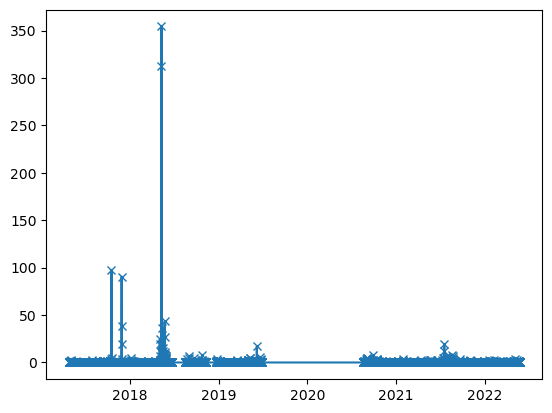

In [78]:
aggre_check = aggregate_per_timestep_xr(check, methods=["mean", "std", "var", "max"], variables=["tp"])
plt.plot(aggre_check.time, aggre_check.mean_tp.where(~aggre_check.mean_tp.isnull()), marker="x")


In [20]:

# Example usage
aggregated_output_output = aggregate_per_timestep_xr(output_output, methods=["mean", "std", "var", "max"], variables=["tp"])
aggregated_output_gt = aggregate_per_timestep_xr(output_gt,  methods=["mean", "std", "var", "max"], variables=["tp"])
#aggregated_input_gt = aggregate_per_timestep_xr(input_gt,  methods=["mean", "std", "var", "max"], variables=["10v"])


In [38]:
filtered_ds = aggregated_output_gt.where(aggregated_output_gt['mean_sp'] >= 900, drop=True)
filtered_output = aggregated_output_output.sel(time=filtered_ds.time)

In [37]:
aggregated_output_gt

<xarray.Dataset>
Dimensions:  (time: 1708)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-31T13:00:00 ... 2022-05-24T16:00:00
Data variables:
    mean_sp  (time) float32 986.0 986.2 985.8 985.9 ... 989.5 989.4 989.4 989.7
    std_sp   (time) float32 0.0001221 6.104e-05 ... 0.0001221 6.104e-05
    var_sp   (time) float32 1.49e-08 3.725e-09 3.725e-09 ... 1.49e-08 3.725e-09
    max_sp   (time) float32 986.0 986.2 985.8 985.9 ... 989.5 989.4 989.4 989.7

In [39]:
filtered_output

<xarray.Dataset>
Dimensions:  (time: 1702)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-31T13:00:00 ... 2022-05-24T16:00:00
Data variables:
    mean_sp  (time) float32 987.1 986.6 986.4 986.4 ... 987.7 990.4 990.5 989.7
    std_sp   (time) float32 0.3024 0.4129 0.397 0.3944 ... 0.9163 0.7242 0.6343
    var_sp   (time) float32 0.09144 0.1704 0.1576 ... 0.8395 0.5245 0.4024
    max_sp   (time) float32 987.7 987.3 987.4 987.3 ... 989.2 991.7 991.5 991.0

In [36]:
filtered_ds

<xarray.Dataset>
Dimensions:  (time: 1702)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-31T13:00:00 ... 2022-05-24T16:00:00
Data variables:
    mean_sp  (time) float32 986.0 986.2 985.8 985.9 ... 989.5 989.4 989.4 989.7
    std_sp   (time) float32 0.0001221 6.104e-05 ... 0.0001221 6.104e-05
    var_sp   (time) float32 1.49e-08 3.725e-09 3.725e-09 ... 1.49e-08 3.725e-09
    max_sp   (time) float32 986.0 986.2 985.8 985.9 ... 989.5 989.4 989.4 989.7

In [121]:
aggregated_output_output.mean_tp.values.mean()

0.1107853

In [122]:
aggregated_output_output

<xarray.Dataset>
Dimensions:  (time: 3209)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-10T19:00:00 ... 2022-05-24T16:00:00
Data variables:
    mean_tp  (time) float32 0.08163 0.07621 0.07696 ... 0.6403 0.6508 0.6672
    std_tp   (time) float32 0.007853 0.00823 0.008256 ... 0.06646 0.06757
    var_tp   (time) float32 6.167e-05 6.774e-05 6.816e-05 ... 0.004417 0.004566
    max_tp   (time) float32 0.105 0.1006 0.1013 0.1006 ... 0.8108 0.8046 0.8026

In [94]:
aggregated_output_output =aggregated_output_output.sortby('time')
aggregated_output_gt =aggregated_output_gt.sortby('time')


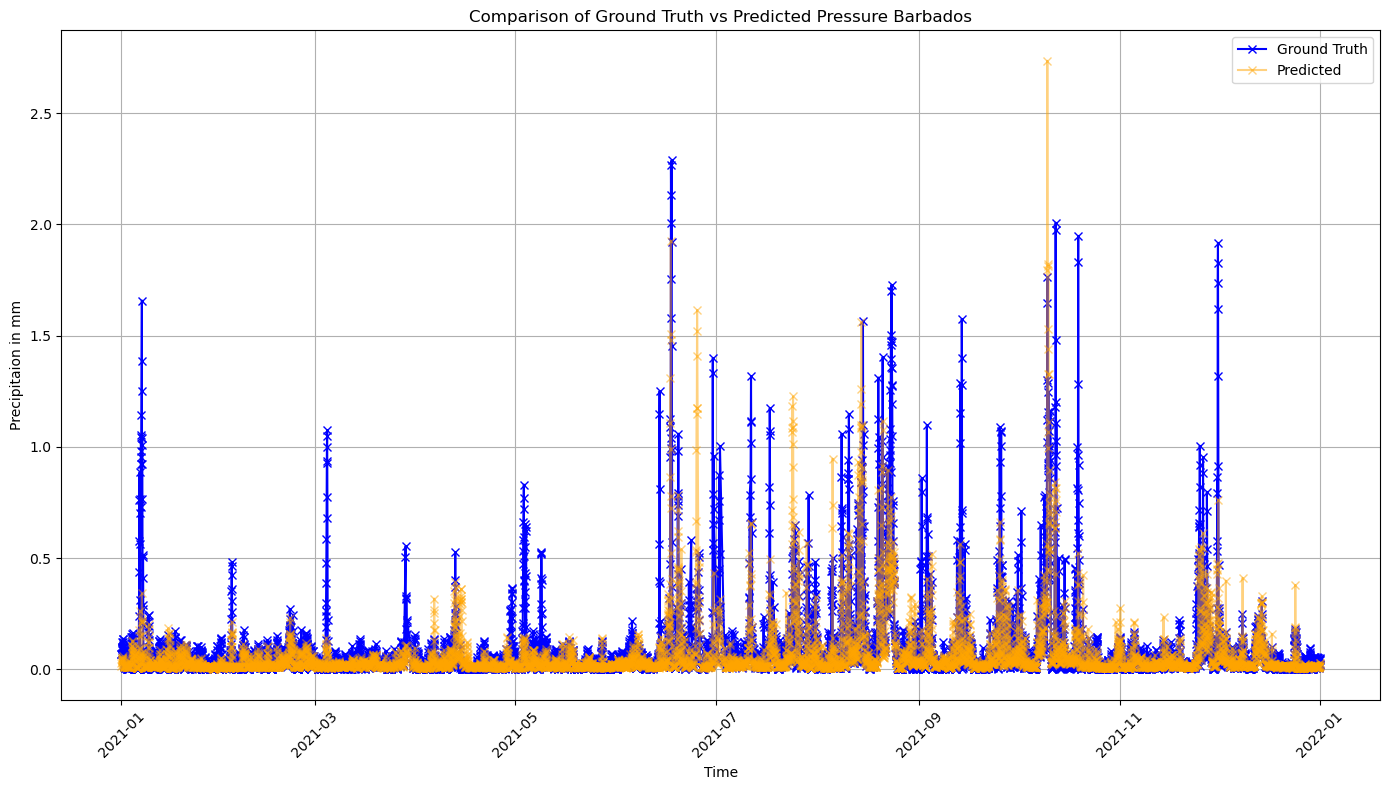

In [21]:
def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, title1="Ground Truth", title2="Predicted"):
    """
    Improved plot for two xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot.
    ds2 (xr.DataArray): Second DataArray to plot.
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2 = xr.align(ds1, ds2)

    # Create a larger figure
    plt.figure(figsize=(14, 8))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.where(~ds1.isnull()), label=title1, marker='x', linestyle='-', color='blue')
    plt.plot(ds2.time, ds2.where(~ds2.isnull()), label=title2, marker='x', linestyle='-', color='orange', alpha=0.5)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    #plt.ylim(950, 1050)  # Note: reversed y-axis

    plt.ylabel('Precipitaion in mm')
    plt.title('Comparison of Ground Truth vs Predicted Pressure Barbados')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
improved_plot_datasets(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp )


In [120]:
# Load the ERA5 dataset
era5_ds  = xr.open_dataset('era5_data/er5_newhook/vienna_allvar_2017-2024_renamed.nc')

# Define the target latitude and longitude
station_lat = 48.2303
station_lon =  16.3609   # Example: Vienna longitude

# Select the nearest grid point
nearest_grid_point = era5_ds.sel(lat=station_lat, lon=station_lon, method="nearest")


# Access a specific variable if needed
variable_nearest_grid = nearest_grid_point["tp"] 

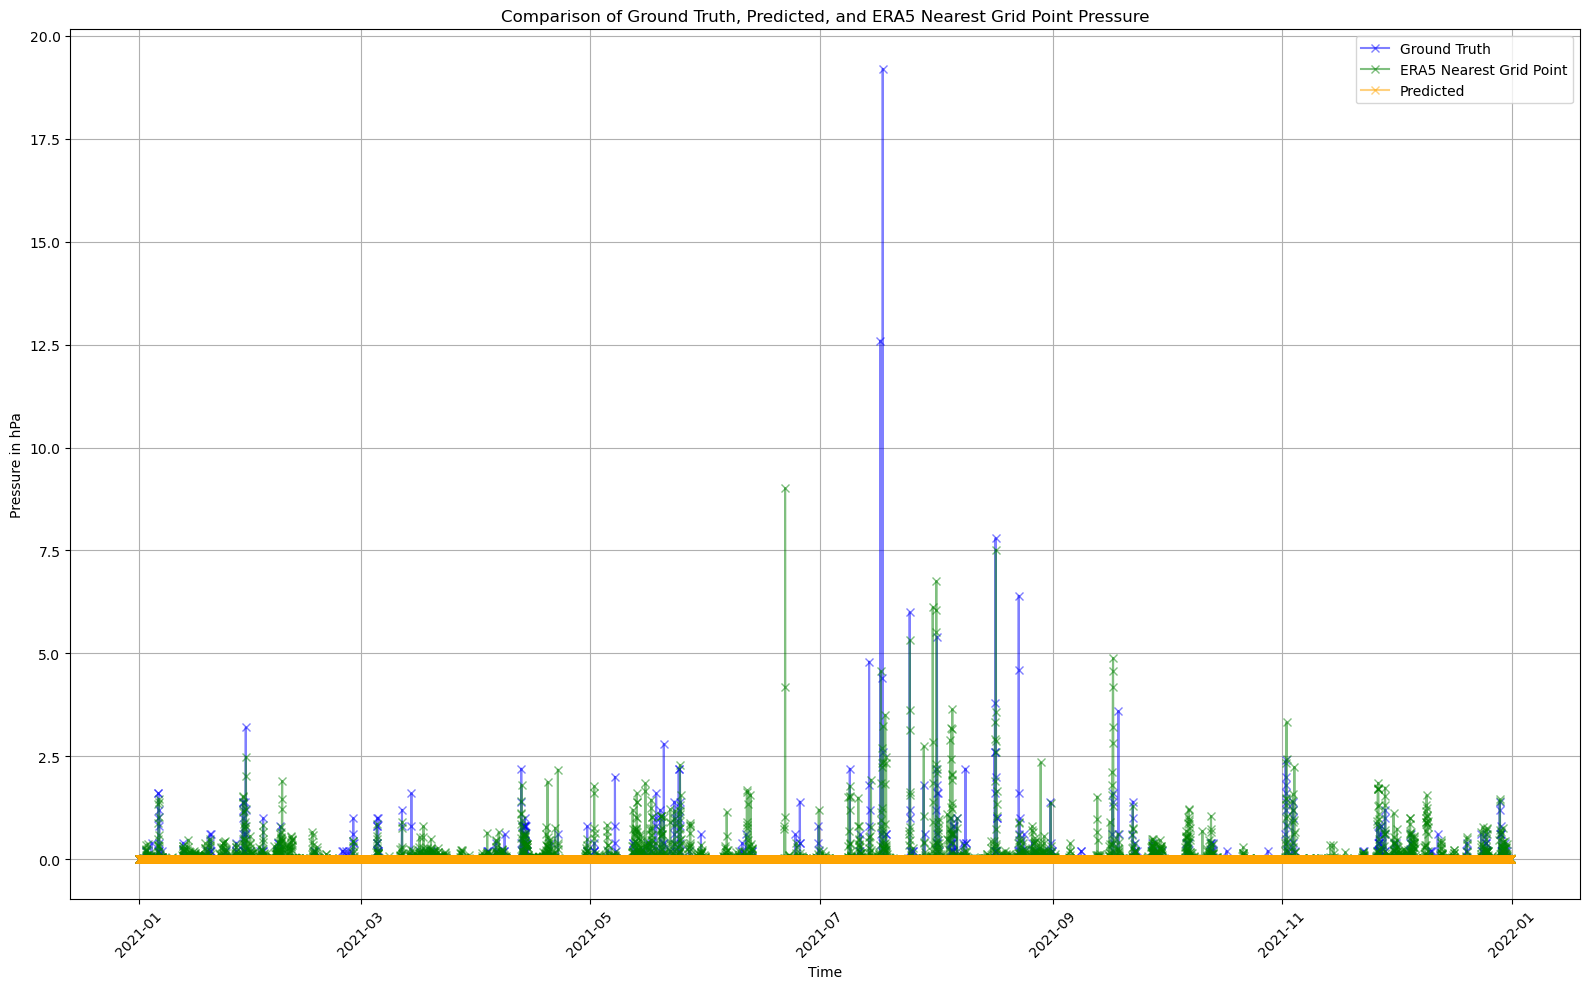

In [124]:


def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, ds3: xr.DataArray,
                           title1="Ground Truth", title2="Predicted", title3="ERA5 Nearest Grid Point"):
    """
    Improved plot for three xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot (e.g., Ground Truth).
    ds2 (xr.DataArray): Second DataArray to plot (e.g., Predicted).
    ds3 (xr.DataArray): Third DataArray to plot (e.g., ERA5 Nearest Grid Point).
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    title3 (str): Label for the third dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2, ds3 = xr.align(ds1, ds2, ds3)

    # Create a larger figure
    plt.figure(figsize=(16, 10))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.where(~ds1.isnull()), label=title1, marker='x', linestyle='-', color='blue', alpha=0.5)
    plt.plot(ds3.time, ds3.where(~ds3.isnull()), label=title3, marker='x', linestyle='-', color='green', alpha=0.5)

    plt.plot(ds2.time, ds2.where(~ds2.isnull()), label=title2, marker='x', linestyle='-', color='orange', alpha=0.5)

    # Adding labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Pressure in hPa')
    plt.title('Comparison of Ground Truth, Predicted, and ERA5 Nearest Grid Point Pressure')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
improved_plot_datasets(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp, variable_nearest_grid)


In [22]:
# Example usage
metrics = calculate_metrics(aggregated_output_gt.mean_tp, aggregated_output_output.mean_tp , var="tp", output_path= "executed_trainings/Barbados_tp_sixvar_nonzero_20241127-17/model/mertics.txt")



In [23]:
print(metrics)


{'R^2': 0.4519501179567531, 'RMSE': 0.14511362, 'Pearson Correlation': 0.6891083876836529}


In [35]:
test_gt = xr.open_dataset("executed_trainings/Barbados_tp_sixvar_nonzero_20241127-17/data/test/output.nc")
test_gt

TypeError: 'method' object is not subscriptable

In [109]:
test_input_u = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/data/test/input_u.nc")
test_input_u["10u"].values[0]

array([[-1.398737  , -1.3579655 , -1.3108463 , -1.2863102 , -1.33111   ,
        -1.4429264 , -1.5455875 , -1.5154362 ],
       [-1.4585514 , -1.4467106 , -1.4202213 , -1.3539371 , -1.3079166 ,
        -1.3535709 , -1.36236   , -1.2986393 ],
       [-1.7867985 , -1.6057682 , -1.4885807 , -1.3114567 , -1.1271305 ,
        -0.9340153 , -0.8002262 , -0.67583656],
       [-2.3317204 , -1.9158268 , -1.4262028 , -0.99004555, -0.5656071 ,
        -0.22600746,  0.03253746,  0.16217613],
       [-2.7943668 , -2.3169498 , -1.6589909 , -0.947443  , -0.37859535,
         0.16327477,  0.6239681 ,  0.95075035],
       [-2.5165348 , -2.2665348 , -1.8950748 , -1.2673893 , -0.60271645,
         0.14728355,  0.7857113 ,  1.299017  ],
       [-1.3834782 , -1.3980045 , -1.3181705 , -1.294611  , -0.7921696 ,
        -0.13482094,  0.5322933 ,  1.1638851 ],
       [-0.63884926, -0.80205727, -0.9298649 , -0.9331608 , -0.67705727,
        -0.31328773,  0.2457943 ,  0.8822689 ]], dtype=float32)

In [110]:
test_input_v = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/data/test/input_v.nc")
test_input_v["10v"].values[0]

array([[-0.6792536 , -0.6681452 , -0.57085514, -0.62969303, -0.87432194,
        -1.2987604 , -1.7662897 , -2.1952448 ],
       [-0.49150944, -0.5610895 , -0.71880436, -0.9395075 , -1.2419977 ,
        -1.5980768 , -2.0002985 , -2.4275446 ],
       [-0.48003483, -0.6248102 , -0.85906315, -1.2249079 , -1.617486  ,
        -1.966485  , -2.2799616 , -2.5374079 ],
       [ 0.01093197, -0.39531803, -0.88579655, -1.4345026 , -1.9292536 ,
        -2.2871637 , -2.4707575 , -2.5552301 ],
       [-0.60295963, -0.8452692 , -1.2366266 , -1.6058893 , -2.0310602 ,
        -2.3633356 , -2.53753   , -2.6438532 ],
       [-1.5249567 , -1.3867731 , -1.3054743 , -1.504693  , -1.8787165 ,
        -2.2367487 , -2.530694  , -2.6687555 ],
       [-0.6689997 , -0.46892643, -0.40142155, -0.7363825 , -1.223321  ,
        -1.7075739 , -2.1519098 , -2.3938532 ],
       [ 0.89960384,  0.9441595 ,  0.7302923 ,  0.33917904, -0.3494196 ,
        -1.0481501 , -1.5332575 , -1.8594294 ]], dtype=float32)

In [111]:
test_gt_v = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/data/test/gt_v.nc")
test_gt_v["10v"].values[0]

array([[-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329],
       [-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329],
       [-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329],
       [-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329],
       [-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329],
       [-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329],
       [-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329],
       [-0.17638329, -0.17638329, -0.17638329, -0.17638329, -0.17638329,
        -0.17638329, -0.17638329, -0.17638329]], dtype=float32)

In [112]:
output_output_v = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/model/v__output.nc")
output_output_v["10v"].values[0]

array([[0.29981235, 0.29840946, 0.29884169, 0.30110464, 0.30632442,
        0.31155822, 0.31630728, 0.319991  ],
       [0.30789077, 0.30726123, 0.30848545, 0.30759588, 0.30982324,
        0.31130016, 0.31542724, 0.31733006],
       [0.31466314, 0.31438914, 0.3184113 , 0.31631243, 0.3168881 ,
        0.315348  , 0.31820244, 0.31896824],
       [0.3049823 , 0.30899793, 0.31806543, 0.31969425, 0.32095274,
        0.31626588, 0.3161247 , 0.31323674],
       [0.28802702, 0.29497218, 0.3073423 , 0.3157447 , 0.3212264 ,
        0.31774035, 0.31601033, 0.31068978],
       [0.25828078, 0.26685655, 0.28033814, 0.29838184, 0.3114681 ,
        0.31279454, 0.30984294, 0.30186903],
       [0.23831624, 0.2459541 , 0.25788692, 0.27946028, 0.29722676,
        0.30321082, 0.30152288, 0.2937251 ],
       [0.21863365, 0.22725812, 0.23916587, 0.2651943 , 0.28694633,
        0.2964696 , 0.2949623 , 0.2875692 ]], dtype=float32)

In [113]:
output_output_u = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/model/u__output.nc")
output_output_u["10u"].values[0]

array([[0.31275636, 0.31042513, 0.31066   , 0.31230497, 0.31604698,
        0.31990272, 0.32353848, 0.32387358],
       [0.31843904, 0.317257  , 0.3182272 , 0.3174552 , 0.31909156,
        0.32014298, 0.32330704, 0.32446325],
       [0.32272   , 0.32255816, 0.3256358 , 0.32403266, 0.3246051 ,
        0.3233227 , 0.3254887 , 0.32584035],
       [0.31582198, 0.31835783, 0.32523337, 0.32644033, 0.32751682,
        0.32375902, 0.32360905, 0.321247  ],
       [0.30330944, 0.30801964, 0.31727332, 0.32354647, 0.32767734,
        0.3248613 , 0.32353508, 0.31926647],
       [0.28057635, 0.28734985, 0.29739034, 0.31082422, 0.32046124,
        0.32096332, 0.31864083, 0.3122772 ],
       [0.26516116, 0.27185547, 0.28075036, 0.2968195 , 0.309825  ,
        0.31397495, 0.3125678 , 0.30631325],
       [0.24930638, 0.2566943 , 0.26565588, 0.28523317, 0.3015226 ,
        0.3085236 , 0.3071966 , 0.30040994]], dtype=float32)

In [114]:
output_gt_u = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/model/u__gt.nc")
output_gt_u["10u"].values[0]

array([[0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914],
       [0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914],
       [0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914],
       [0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914],
       [0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914],
       [0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914],
       [0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914],
       [0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914, 0.7219914,
        0.7219914, 0.7219914]], dtype=float32)

In [115]:
output_gt_v = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/model/v__gt.nc")
output_gt_v["10v"].values[0]

array([[0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799],
       [0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799],
       [0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799],
       [0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799],
       [0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799],
       [0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799],
       [0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799],
       [0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799, 0.8445799,
        0.8445799, 0.8445799]], dtype=float32)

In [64]:
input_u = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/model/u__output.nc")
input_u

<xarray.Dataset>
Dimensions:  (lon: 8, lat: 8, time: 1641)
Coordinates:
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
  * time     (time) datetime64[ns] 2019-04-21T12:00:00 ... 2019-06-30T02:00:00
Data variables:
    10u      (time, lat, lon) float32 ...

In [50]:
input_u = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/model/v__output.nc")
input_u["10v"]

<xarray.DataArray '10v' (time: 1641, lat: 8, lon: 8)>
[105024 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
  * time     (time) datetime64[ns] 2019-04-21T12:00:00 ... 2019-06-30T02:00:00

In [48]:
input_u = xr.open_dataset("executed_trainings/Vienna_wind_20241125-11/model/v__gt.nc")
input_u

<xarray.Dataset>
Dimensions:  (lon: 8, lat: 8, time: 1641)
Coordinates:
  * lon      (lon) float64 15.36 15.61 15.86 16.11 16.36 16.61 16.86 17.11
  * lat      (lat) float64 49.23 48.98 48.73 48.48 48.23 47.98 47.73 47.48
  * time     (time) datetime64[ns] 2019-04-21T12:00:00 ... 2019-06-30T02:00:00
Data variables:
    10v      (time, lat, lon) float32 ...